# First Steps with Tensorflow
This is an introductory notebook, intended to illustrate some fundamental ML concepts using TensorFlow.

In this notebook, we'll be creating a linear regression model to predict median housing price, at the granularity of city blocks, based on one input feature. The data is based on 1990 census data from California.

## Set Up
In this first cell, we'll load the necessary libraries.

In [5]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Next, we'll load our data set.

In [6]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

In [36]:
print ('size: {}'.format(california_housing_dataframe.size))
print ('axes is a {}'.format(type(california_housing_dataframe.axes)))
print ('shape: {}'.format(california_housing_dataframe.shape))



size: 153000
axes is a <type 'list'>
shape: (17000, 9)


In [35]:
# dataset col is a Series object
type (california_housing_dataframe["total_rooms"])

pandas.core.series.Series

In [60]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [59]:
california_housing_dataframe.index[1]

1

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [61]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4060,-118.0,33.7,26.0,2553.0,405.0,1337.0,411.0,5.4,252.9
9887,-119.7,36.3,40.0,1185.0,221.0,676.0,256.0,2.3,52.6
14786,-122.2,37.5,30.0,1170.0,258.0,610.0,243.0,3.4,263.5
15771,-122.4,37.8,30.0,1821.0,738.0,1648.0,684.0,0.9,450.0
3194,-117.8,34.1,25.0,9255.0,1659.0,4944.0,1627.0,4.6,223.0


## Examine the data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column.

This will include things like mean, standard deviation, max, min, and various quantiles.

In [62]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


## Build the first model

In this exercise, we'll be trying to predict `median_house_value`. It will be our label (sometimes also called a target). We'll use `total_rooms` as our input feature.

Recall that this data is at the city block level, so these features reflect the total number of rooms in that block, or the total number of people who live on that block, respectively.

To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/versions/master/api_docs/python/contrib.learn.html#LinearRegressor) interface provided by the TensorFlow [contrib.learn](https://www.tensorflow.org/versions/master/tutorials/tflearn/index.html) library. This library takes care of a lot of the plumbing, and exposes a convenient way to interact with data, training, and evaluation.

First, we define the input feature, the target, and create the `LinearRegressor` object.

The GradientDescentOptimizer implements Mini-Batch Stochastic Gradient Descent (SGD), where the size of the mini-batch is given by the `batch_size` parameter. Note the `learning_rate` parameter to the optimizer: it controls the size of the gradient step. We also include a value for `gradient_clip_norm` for safety. This makes sure that gradients are never too huge, which helps avoid pathological cases in gradient descent.

In [63]:
my_feature = california_housing_dataframe[["total_rooms"]]
targets = california_housing_dataframe["median_house_value"]

training_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=None, batch_size=1)

feature_columns = [tf.contrib.layers.real_valued_column("total_rooms", dimension=1)]

linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001),
    gradient_clip_norm=5.0,
)

Calling `fit()` on the feature column and targets will train the model.

In [64]:
_ = linear_regressor.fit(
    input_fn=training_input_fn,
    steps=100
)

Let's make predictions on that training data, to see how well we fit the training data.

In [65]:
prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature, y=targets, num_epochs=1, shuffle=False)

predictions = list(linear_regressor.predict(input_fn=prediction_input_fn))
mean_squared_error = metrics.mean_squared_error(predictions, targets)
print "Mean Squared Error (on training data): %0.3f" % mean_squared_error
print "Root Mean Squared Error (on training data): %0.3f" % math.sqrt(mean_squared_error)

Mean Squared Error (on training data): 50907.243
Root Mean Squared Error (on training data): 225.626


### Evaluate the model

Okay, training the model was easy!  But is this a good model?  How would you judge how large this error is?

The mean squared error can be hard to interpret, so we often look at root mean squared error (RMSE)
instead.  RMSE has the nice property that it can be interpreted on the same scale as the original targets.

Compare the RMSE with the range between min and max of our targets.  How does the RMSE compare to this range?

Can we do better?

This is the question that nags every model developer. Let's develop some basic strategies to help give some guidance.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [66]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data.  This is helpful to make the scatter plot readable.

In [67]:
sample = california_housing_dataframe.sample(n=300)

Then, plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

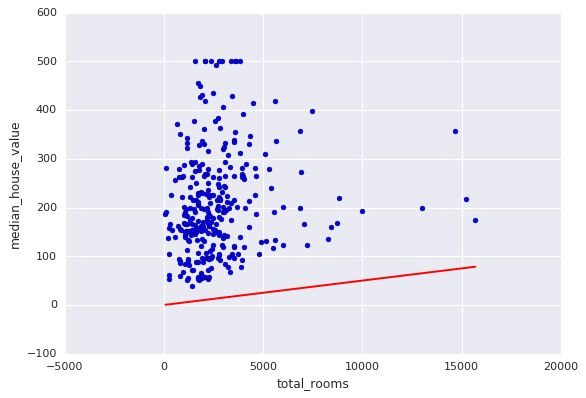

In [68]:
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
y_0 = linear_regressor.weights_[0] * x_0 + linear_regressor.bias_
y_1 = linear_regressor.weights_[0] * x_1 + linear_regressor.bias_
plt.plot([x_0, x_1], [y_0, y_1], c='r')
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")
plt.scatter(sample["total_rooms"], sample["median_house_value"])
plt.show()

This initial line looks way off.  See if you can look back at the summary stats and see the same information encoded there.

Together, these initial sanity checks suggest we may be able to find a much better line.

### Tweak the model parameters
For this exercise, we've put all the above code in a single function for convenience. You can call the function with different parameters to see the effect.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute training loss and graph that.  This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot values for the feature weight and bias term learned by the model over time.  This is another way to see how things converge.

In [69]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_column = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns
  feature_columns = [tf.contrib.layers.real_valued_column(my_feature, dimension=1)]
  
  # Create input functions
  training_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=None, batch_size=batch_size)
  prediction_input_fn = learn_io.pandas_input_fn(
    x=my_feature_column, y=targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = list(linear_regressor.predict(
        input_fn=prediction_input_fn))
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    x_extents = (y_extents - linear_regressor.bias_) / linear_regressor.weights_[0]
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = linear_regressor.weights_[0] * x_extents + linear_regressor.bias_
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print "Final RMSE (on training data): %0.2f" % root_mean_squared_error

### Task 1:  Tweak to try and improve loss and match the target distribution better.

**Your goal is to try and get anything below about 180 in RMSE for this portion.**

If you haven't gotten 180 or lower RMSE after 5 minutes of trying, check the solution for a possible combination.

Training model...
RMSE (on training data):
  period 00 : 236.32
  period 01 : 235.11
  period 02 : 233.90
  period 03 : 232.70
  period 04 : 231.50
  period 05 : 230.31
  period 06 : 229.13
  period 07 : 227.96
  period 08 : 226.79
  period 09 : 225.63
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


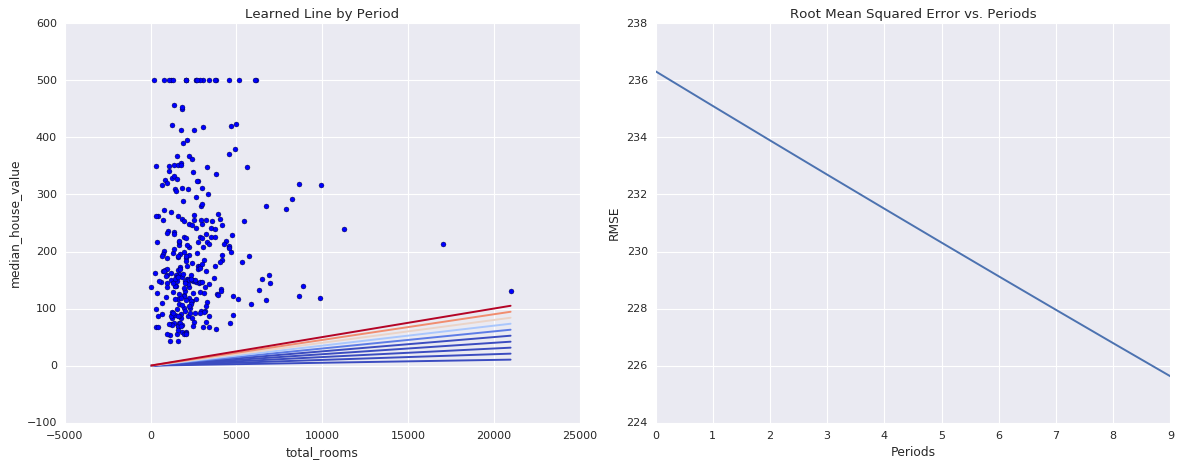

In [70]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

### Is there a standard method for tuning the model?

This is a commonly asked question. The short answer is that the effects of different hyperparameters is data dependent.  So there are no hard and fast rules; you'll need to run tests on your data.

Here are a few rules of thumb that may help guide you:

 * Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
 * If the training has not converged, try running it for longer.
 * If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
   * But sometimes the exact opposite may happen if the learning rate is too high.
 * If the training error varies wildly, try decreasing the learning rate.
   * Lower learning rate plus larger number of steps or larger batch size is often a good combination.
 * Very small batch sizes can also cause instability.  First try larger values like 100 or 1000, and decrease until you see degradation.

Again, never go strictly by these rules of thumb, because the effects are data depdendent.  Always experiment and verify.

### Task 2: Try a different feature.

See if you can do any better by replacing the `total_rooms` feature with the `population` feature.

Don't take more than 5 minutes on this portion.